### Preparando o Ambiente

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
nltk.download('movie_reviws')
nltk.download('punkt')

from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer

import translators as ts

A biblioteca pandas será utilizada para podermos transformar os arquivos de texto em conjuntos de dados. Ela auxiliará com funções próprias o tratamento desses dados também.

A biblioteca NLTK é um conjunto de bibliotecas e programas que processam strings em linguagem natural e retornam dados estátisticos sobre o texto. No caso foi utilizado os pacotes movie_revis punkt para poder acessar algumas ferramentas da biblioteca.
Por meio dessa biblioteca foi possível utilizar o pacote textblob, que possui um algoritmo que identifica os sentimentos de uma string.

Foi usado a fim de testes a biblioteca "translators", que utiliza-se de APIs externas para traduzir os textos.
<div>
<img src="https://miro.medium.com/max/1400/1*wC3LH4Xe90U8guP9jBgBVg.png" width="800"/>
</div>
https://towardsdatascience.com/language-translation-using-python-bd8020772ccc

A biblioteca acabou não sendo utilizada pelo tempo que demoraria para cada requisição chegar. A cada diálogo era lançada uma requisição que inseria em um novo arquivo CSV as falas traduzidas para inglês.

### Extraindo os Dados

In [132]:
roteiro = open('data/SW_EpisodeIV_ptBR.txt', 'r')

roteiro_csv = open('data/roteiroIV.csv', 'w')

ct = 0
for i in roteiro:
    x = i.split(f'"')

    if ct != 0:
        roteiro_csv.write(f'"{x[3]}";"{x[5]}"\n')
    else:
        roteiro_csv.write(f'"{x[1]}";"{x[3]}"\n')
    ct+=1

roteiro_csv.close()
roteiro.close()

Ao abrirmos o arquivo .txt que possui o roteiro do filme, é possível notar que ele é estruturado da seguinte maneira: "Personagem" "Diálogo".

Logo, criando laço de repetição é possível ler linha por linha do arquivo, separar o personagem do diálogo e inseri-los separadamente numa estrutura de arquivo .csv em um novo arquivo que poderá ser explorado para a análise.

In [393]:
df = pd.read_csv('data/roteiroIV.csv', sep=";")
df.rename(columns={'diálogo': 'dialogo'}, inplace=True)

A variável "df" receberá o conjunto de dados extraídos do arquivo CSV

### Tratando os Dados

In [395]:
top5 = df['personagem'].value_counts().keys()[0:5]

Ao chamar a função "value_counts()" em uma coluna de um conjunto de dados, ela retornará um resumo dos dados mais repetidos de tal coluna de maneira decrescente. Isso gera um dicionário com chave e valor, ao capturarmos apenas as primeiras cinco chaves, conseguimos capturar os primeiros cinco nomes que logicamente são os personagens com mais falas no roteiro.

In [396]:
dict_falas = {}

for i in top5:
    dict_falas[f'{i}'] = df.loc[(df['personagem'] == i), ['dialogo']]

Foi criado uma objeto do tipo dicionário que armazena como chave o personagem e suas falas.
A propriedade "loc" de um conjunto de dados retorna um grupo de linhas e colunas de acordo com os parâmetros passados. No caso, era necessário pegar a coluna de diálogo de cada personagem.

In [ ]:
roteiro_csv_en = open('data/roteiroIVen.csv', 'w')
roteiro_csv_en.write('"character";"dialogue"\n')

for i in top5:
    for j in dict_falas[i]['dialogo']:
        roteiro_csv_en.write('"{}";"{}"\n'.format(i, ts.google(j, from_language='pt', to_language='en')))

Demonstração da bilbioteca de tradução funcionando e inserindo o retorno em um novo arquivo.

In [421]:
df = pd.read_csv('data/roteiroIVen.csv', sep=";")
top5 = df['character'].value_counts().keys()[0:5]

dict_falas_en = {}

for i in top5:
    dict_falas_en[f'{i}'] = df.loc[(df['character'] == i), ['dialogue']]

Como não foi possível traduzir pela biblioteca, o trabalho foi feito a mão pelo Google Tradutor.
Novamente foi separado os personagens com mais falas e seus diálogos. É necessário executar esta atividade novamente por conta de uma diferenciação que a tradução traz.

### Analisando os Dados

In [135]:
cols = ('character', 'dialogue', 'class', 'pos_value', 'neg_value')
df_sents = pd.DataFrame(columns = cols)

for i in dict_falas_en:
    for j in dict_falas_en[i]['dialogue']:
            pos = TextBlob(j, analyzer=NaiveBayesAnalyzer()).sentiment[1]
            neg = 1 - pos
            prob = ''
            
            if pos >= 0.75:
                prob = 'pos'
            elif pos <= 0.25:
                prob = 'neg'
            else:
                prob = 'neu'

            linha = pd.Series({'character': i, 'dialogue': j, 'class': prob, 'pos_value': pos, 'neg_value': neg})
            df_sents = pd.concat([df_sents, pd.DataFrame([linha], columns=linha.index)])

Para que fosse classificada cada frase do filme, foi necessário utilizar laços de repetição para capturar as falas e implementasse a ferramenta de processamento de linguagem natural.

Ela retornava uma tupla com alguns dados ao chamar a propriedade "sentiment". No caso, esse retorno devolvia respectivamente: "classificacao", "probabilidade positiva" e "probabilidade negativa".

No código fora capturado todos esses dados e implementados dentro de um objeto do tipo Series (Pandas) que recebia um dicionário para que fosse concatenado com o restante do conjunto de dados.

E vua-la, temos um conjunto de dados com as frases classificadas de acordo com os sentimentos passados.

In [291]:
# df_sents.to_csv('data/roteiroIVclassificado.csv')

Agora o conjunto de dados era exportado como CSV para que o trabalho de processamento que durou horas não fosse perdido.

In [435]:
df = pd.read_csv('data/roteiroIVclassificado.csv', sep=";").dropna()

Esse conjunto é importado novamente e eliminamos todas as colunas que possívelmente estejam não integras.

In [400]:
def percent(personagem, value):
    x = df.loc[(df['character'] == personagem), [value]]
    ct = count = 0

    for i in x[value]:
        ct += float(i)
        count += 1
    
    return round(ct / count, 2)

Foi criada essa função "percent" para poder puxar a quantidade total de algum campo ("value") e depois se dividia pela quantidades de repetição, criando-se assim a média em porcentagem.

Como esse valor também era passado para seu campo oposto, as médias se tornavam porcentagens para descobrir como o algoritmo da ferramenta se comportou com as falas de cada personagem.
(Usado no primeiro plot)

In [518]:
estatisticas = {}

for i in df['character'].value_counts().keys():
    estatisticas[i] = {
        'pos': df.loc[(df['character'] == i) & (df['class'] == 'pos'), ['class']].value_counts(),
        'pos_percent': percent(i, 'pos_value') * 100,
        'neg': df.loc[(df['character'] == i) & (df['class'] == 'neg'), ['class']].value_counts(),
        'neg_percent': percent(i, 'neg_value') * 100,
        'neu': df.loc[(df['character'] == i) & (df['class'] == 'neu'), ['class']].value_counts(),
    }

Foi criado um dicionário que recebia todas os personagens do roteiro e criava estatísticas para cada personagem.

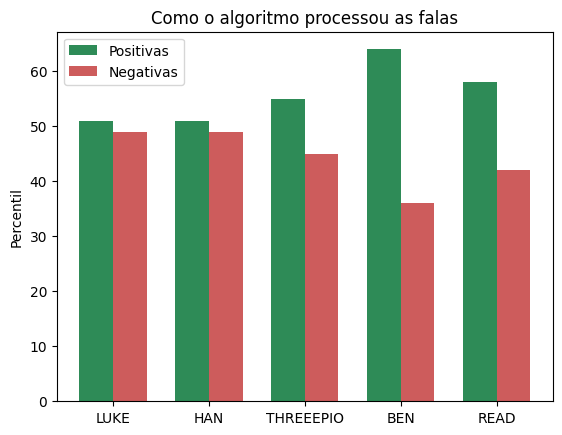

In [521]:
posPercent = negPercent = ()

for i in top5:
    posPercent = posPercent + (estatisticas[i]['pos_percent'],)
    negPercent = negPercent + (estatisticas[i]['neg_percent'],)

ind = np.arange(5)  
width = 0.35

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, posPercent, width, color='seagreen')
rects2 = ax.bar(ind+width, negPercent, width, color='indianred')

ax.set_ylabel('Percentil')
ax.set_title('Como o algoritmo processou as falas')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(top5)

ax.legend((rects1[0], rects2[0]), ('Positivas', 'Negativas'))

plt.show()

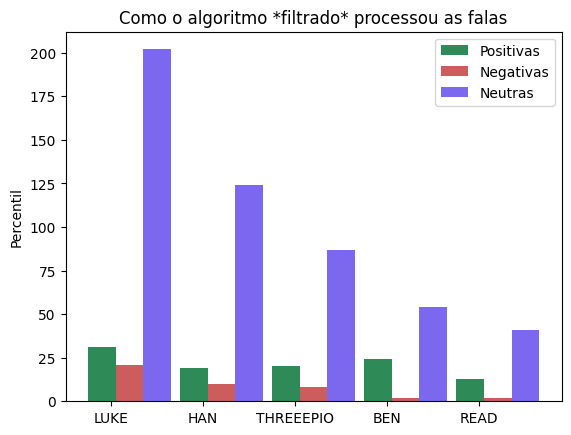

In [522]:
qtdPos = qtdNeg = qtdNeu = ()

for i in top5:  
    qtdPos = qtdPos + (estatisticas[i]['pos'][0],)
    qtdNeg = qtdNeg + (estatisticas[i]['neg'][0],)
    qtdNeu = qtdNeu + (estatisticas[i]['neu'][0],)

ind = np.arange(5)  
width = 0.30

fig = plt.figure()
ax = fig.add_subplot(111)

rects1 = ax.bar(ind, qtdPos, width, color='seagreen')
rects2 = ax.bar(ind+width, qtdNeg, width, color='indianred')
rects3 = ax.bar(ind+width*2, qtdNeu, width, color='mediumslateblue')

ax.set_ylabel('Percentil')
ax.set_title('Como o algoritmo *filtrado* processou as falas')
ax.set_xticks(ind + width / 3)
ax.set_xticklabels(top5)

ax.legend((rects1[0], rects2[0], rects3[0],), ('Positivas', 'Negativas', 'Neutras'))

plt.show()